# CNN-based Agricultural Land Classifier Using Keras and PyTorch 

- This notebook demonstrates Geospatial data analysis to efficiently build and train a binary classifier model from curated satellite dataset to classify images of agricultural and non-agricultural land and answer data science related questions from the AI model
- Demonstrates: efficient data loading, model validation, implementation in Keras and PyTorch
- Possible use-cases: Fertilizer sales forecasting 

In [4]:
%%capture captured_output
import sys
!{sys.executable} -m pip install numpy==1.26
!{sys.executable} -m pip install matplotlib==3.9.2
!{sys.executable} -m pip install tensorflow==2.19
!{sys.executable} -m pip install pandas==2.2.3
!{sys.executable} -m pip install torch==2.7.1
!{sys.executable} -m pip install torchvision==0.22

In [5]:
output_text = captured_output.stdout
lines = output_text.splitlines()
output_last_10_lines = '\n'.join(lines[-10:])
if "error" in output_last_10_lines.lower():
    print("Library installation failed!")
    print("--- Error Details ---")
    print(output_last_10_lines)
else:
    print("Library installation was successful, let's proceed ahead")

Library installation was successful, let's proceed ahead


In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
import os

# Check where we are
print("Current directory:", os.getcwd())

# Always navigate from the base directory
if "SatelliteImageryClassifier" not in os.getcwd():
    print("Navigating to project directory...")
    
    # Go to the correct path
    if "Keras" in os.getcwd():
        os.chdir('./Deep Learning/SatelliteImageryClassifier')
    elif "Deep Learning" in os.getcwd():
        os.chdir('./SatelliteImageryClassifier')
    else:
        # Use absolute path as fallback
        os.chdir('/Users/christopherleggett/Code/AIML_Engineering_Porftolio/Keras/Deep Learning/SatelliteImageryClassifier')

print("Now in:", os.getcwd())

# List files to confirm
print("\nFiles here:")
for file in os.listdir('.'):
    print(f"  {file}")

# Import your custom utils
import geotools as cleggett_geoutils
print("cleggett_geoutils loaded successfully!")

Current directory: /Users/christopherleggett/Code/AIML_Engineering_Porftolio/Keras/Deep Learning/SatelliteImageryClassifier
Now in: /Users/christopherleggett/Code/AIML_Engineering_Porftolio/Keras/Deep Learning/SatelliteImageryClassifier

Files here:
  Magic
  images_dataSAT
  SatelliteClassification.ipynb
  geotools.py
  READMEImages
  .ipynb_checkpoints
cleggett_geoutils loaded successfully!


In [8]:
print("Installing required packages...")
!{sys.executable} -m pip install requests tqdm

Installing required packages...
Defaulting to user installation because normal site-packages is not writeable


In [9]:
print("ChrisLeggett GeoUtils loaded successfully!")
print(f"Available functions: {[attr for attr in dir(cleggett_geoutils) if not attr.startswith('_') and not attr[0].isupper()]}")

# Verify functionality
print(f"Chunk size: {cleggett_geoutils.DEFAULT_CHUNK_SIZE} bytes")
print("Ready for satellite image classification workflow!")

ChrisLeggett GeoUtils loaded successfully!
Available functions: ['asyncio', 'download', 'download_dataset', 'os', 'prepare', 'prepare_dataset', 'read', 'shutil', 'tarfile', 'tqdm', 'urlparse', 'zipfile']
Chunk size: 8192 bytes
Ready for satellite image classification workflow!


### Download Data

In [18]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"

extraction_path = "."
await cleggett_geoutils.prepare(url=url, path=extraction_path, overwrite=True)

  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


Now, you will be able to see the **images_dataSAT** folder in the left pane. It has two folders  **class_0_non_agri** and **class_1_agri**.
The folder structure looks as follows:

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

- class_0_non_agri is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 
- class_1_agri, on the other hand, is the agricultural land class, and it represents the images with cultivable land.


In [19]:
# Define directories
extract_dir = "."

base_dir = os.path.join(extract_dir, 'images_dataSAT')
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

In [20]:
#Read and explore the downloaded datasets to verify file presence
print("\nThe first five files are:")
non_agri = os.scandir(dir_non_agri)
# print first 5 file paths
for f_path in range(5):
    print(next(non_agri))

print("\nThe first file is:")
#Show first file in dir
file_name = next(non_agri)
file_name
print(file_name)

#print image data as array to verify
os.path.isfile(file_name)
image_name = str(file_name).split("'")[1]
image_name

print("\nPrinted image data:")
image_data = plt.imread(os.path.join(dir_non_agri, image_name))
image_data


The first five files are:
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_25907.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_25984.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_15608.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_3487.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_14258.jpg'>

The first file is:
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_25012.jpg'>

Printed image data:


array([[[ 86,  55,  63],
        [ 88,  57,  65],
        [104,  74,  82],
        ...,
        [ 95,  74,  79],
        [100,  79,  84],
        [ 76,  55,  60]],

       [[117,  86,  94],
        [109,  78,  86],
        [103,  73,  81],
        ...,
        [150, 129, 134],
        [153, 132, 137],
        [154, 133, 138]],

       [[159, 128, 136],
        [151, 120, 128],
        [135, 105, 113],
        ...,
        [216, 193, 199],
        [213, 190, 196],
        [241, 218, 224]],

       ...,

       [[ 29,  35,  21],
        [ 29,  35,  21],
        [ 31,  35,  21],
        ...,
        [127, 100, 105],
        [132, 105, 110],
        [123,  96, 101]],

       [[ 34,  40,  26],
        [ 33,  39,  25],
        [ 33,  37,  23],
        ...,
        [ 89,  62,  67],
        [ 95,  68,  73],
        [142, 115, 120]],

       [[ 25,  31,  17],
        [ 25,  31,  17],
        [ 26,  30,  16],
        ...,
        [112,  85,  90],
        [100,  73,  78],
        [ 94,  67,  72]]

The image dimensions are: 
(64, 64, 3)

Sample image:


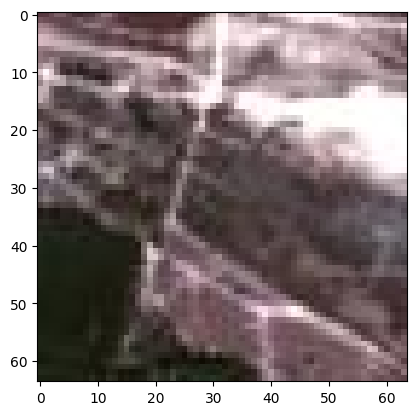

In [21]:
#Image dimensions
print("The image dimensions are: ")
print(image_data.shape)
print("\nSample image:")

plt.imshow(image_data)

Total number of non-agricultural land images in dataset: 3000
Memory loading: 0.480s, Shape: (3000, 64, 64, 3)
Successfully loaded 3000 non-agricultural images into memory


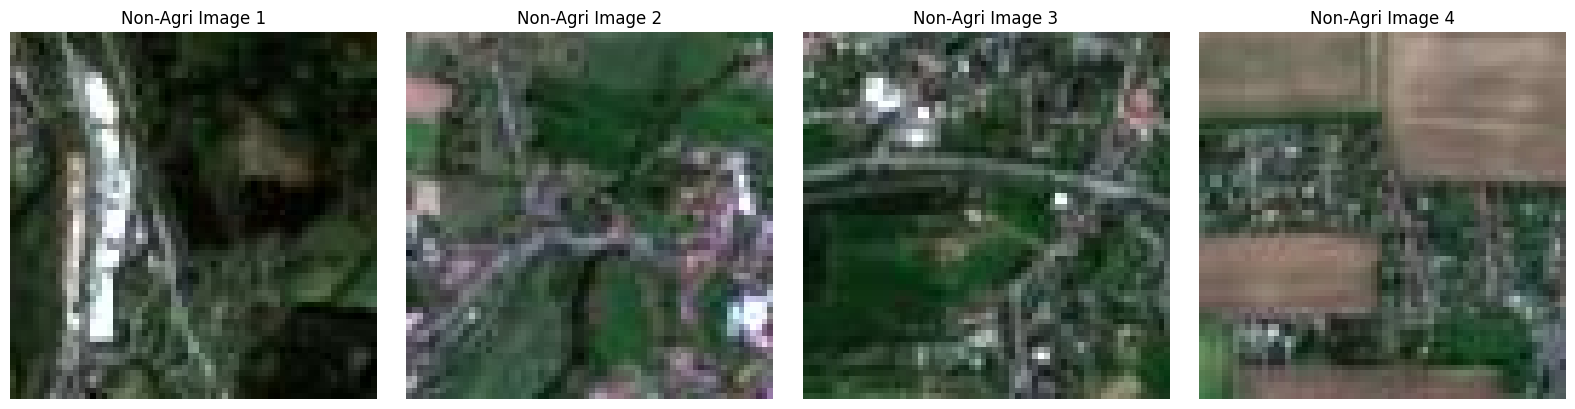

In [22]:
# Loop through all images in ./images_dataSAT/class_0_non_agri directory
# Read them all and save in non_agri_images list
# Memory loading
import time, os, numpy as np, matplotlib.pyplot as plt

start_time = time.time()
dir_non_agri = "./images_dataSAT/class_0_non_agri" 
non_agri_files = [f for f in os.listdir(dir_non_agri) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff'))]

print(f"Total number of non-agricultural land images in dataset: {len(non_agri_files)}")

non_agri_images = []
for file_name in non_agri_files:
    image_data = plt.imread(os.path.join(dir_non_agri, file_name))
    non_agri_images.append(image_data)

non_agri_images = np.array(non_agri_images)
print(f"Memory loading: {time.time() - start_time:.3f}s, Shape: {non_agri_images.shape}")
print(f"Successfully loaded {len(non_agri_images)} non-agricultural images into memory")

# Display first four images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(non_agri_images[i])
    axes[i].set_title(f"Non-Agri Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Total number of agricultural land images in dataset: 3000
Memory loading: 0.486s, Shape: (3000, 64, 64, 3)
Successfully loaded 3000 agricultural images into memory


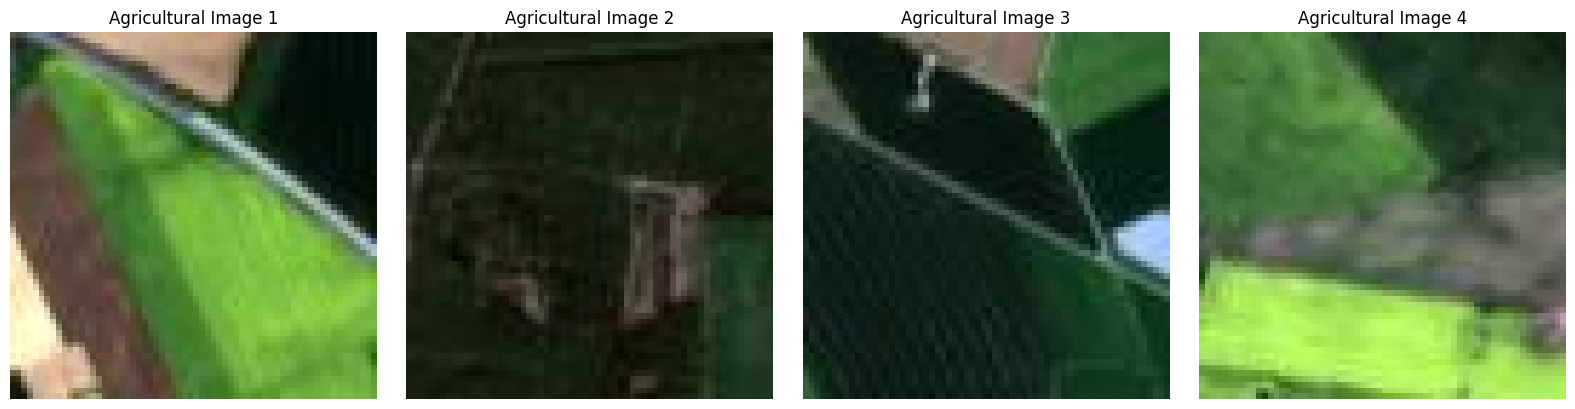

In [105]:
# Load AGRICULTURAL images (Class 1) - Memory loading approach
import time, os, numpy as np, matplotlib.pyplot as plt

start_time = time.time()
dir_agri = "./images_dataSAT/class_1_agri"
agri_files = [f for f in os.listdir(dir_agri) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff'))]

print(f"Total number of agricultural land images in dataset: {len(agri_files)}")

agri_images = []
for file_name in agri_files:
    image_data = plt.imread(os.path.join(dir_agri, file_name))
    agri_images.append(image_data)

agri_images = np.array(agri_images)
print(f"Memory loading: {time.time() - start_time:.3f}s, Shape: {agri_images.shape}")
print(f"Successfully loaded {len(agri_images)} agricultural images into memory")

# Display first four agricultural images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(agri_images[i])
    axes[i].set_title(f"Agricultural Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### Data loading and augmentation

- Define your directory structure
- Single source of truth for directory paths
- Easy to modify if dataset structure changes

In [59]:
# Define dataset path and verify it exists
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

# Define directories
base_dir = './images_dataSAT/'
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

# Initialize empty lists to store paths and labels
all_image_paths = []
all_labels = []

# define the labels for each class
label_non_agri = 0
label_agri = 1

# populate the lists

for fname in os.listdir(dir_non_agri):
    all_image_paths.append(os.path.join(dir_non_agri, fname))
    all_labels.append(label_non_agri)

for fname in os.listdir(dir_agri):
    all_image_paths.append(os.path.join(dir_agri, fname))
    all_labels.append(label_agri)

# Use zip to bind paths and labels, then shuffle this list of pairs
temp = list(zip(all_image_paths, all_labels))
np.random.shuffle(temp)
all_image_paths, all_labels = zip(*temp)

print("First 5 paths and labels (after shuffling):", list(zip(all_image_paths[:5], all_labels[:5])))

./images_dataSAT
First 5 paths and labels (after shuffling): [('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_6754.jpg', 0), ('./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_8711.jpg', 1), ('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_8275.jpg', 0), ('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_12008.jpg', 0), ('./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_7823.jpg', 1)]


### Generator Based Loading
- Note we already have implemented memory based loading.  These functions implement lazy loading which present an alternative means of loading the data. 

In [54]:
def custom_data_generator(image_paths, labels, batch_size, target_size=(64, 64)):
    """A custom data generator to feed a Keras model."""
    num_samples = len(image_paths)
    while True: 
        # Shuffle data at the beginning of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        shuffled_paths = np.array(image_paths)[indices]
        shuffled_labels = np.array(labels)[indices]
        
        # Generate batch data
        for offset in range(0, num_samples, batch_size):
            batch_paths = shuffled_paths[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]
            
            # Load and preprocess images from the batch
            batch_images = []
            for path in batch_paths:
                img = tf.keras.utils.load_img(path, target_size=target_size)
                img_array = tf.keras.utils.img_to_array(img)
                batch_images.append(img_array)
            
            # Normalize and yield the batch data
            yield np.array(batch_images) / 255.0, np.array(batch_labels)

Images batch shape: (8, 64, 64, 3)
Labels batch shape: (8,)


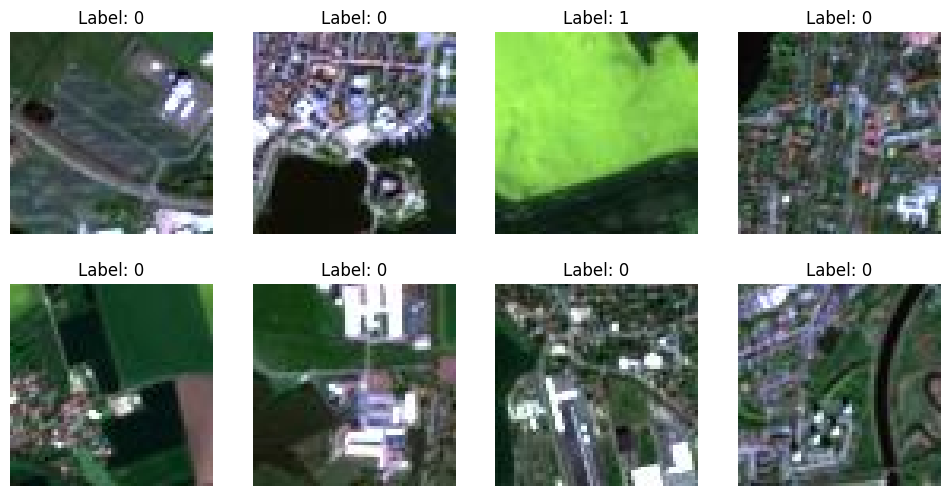

In [55]:
batch_size = 8
data_generator = custom_data_generator(image_paths=all_image_paths, 
                                       labels=all_labels, 
                                       batch_size=batch_size)
 
# Get one batch data
images, labels = next(data_generator)
 
# Print batch data statistics
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
 
# Display the images in the batch
plt.figure(figsize=(12, 6))
for i in range(batch_size):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

In [26]:
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 8

# Create a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',          # Labels are generated from directory structure
    label_mode='int',           # Labels are encoded as integers (0, 1, ...)
    validation_split=0.2,       # Reserve 20% of images for validation
    subset='training',          # This is the training set
    seed=1337,                  # Shuffle seed for reproducible splits
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True  # Force shuffling
)

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


In [27]:
#Create validation dataset with batch size 8

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


Generator output - Image range: 0.000 to 1.000
Labels: [1 0 0 0 1 0 1 0]


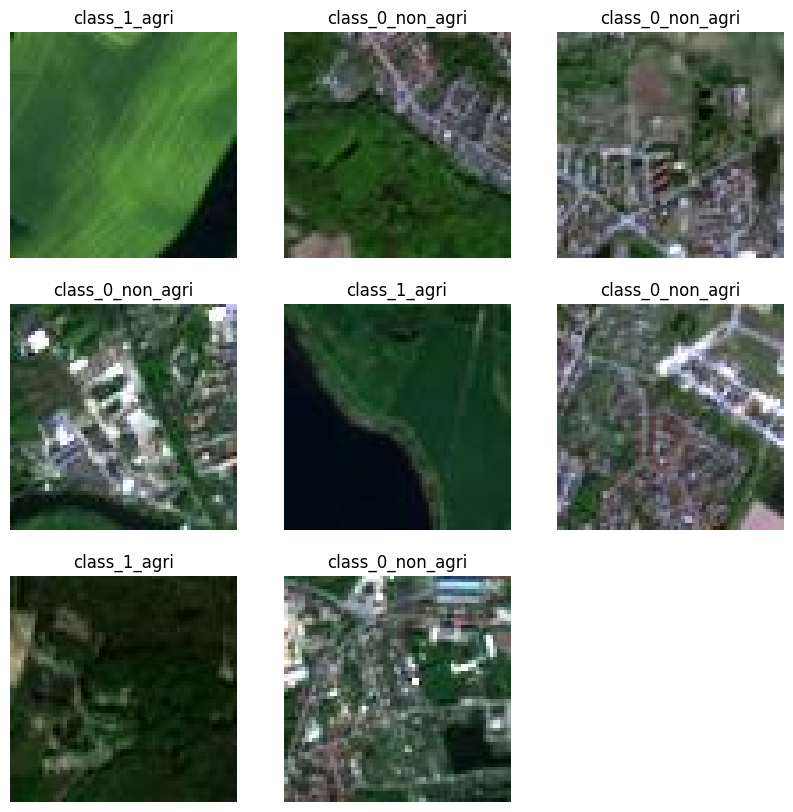

In [28]:
generator = custom_data_generator(all_image_paths, all_labels, BATCH_SIZE)
images, labels = next(generator)

print(f"Generator output - Image range: {images.min():.3f} to {images.max():.3f}")
print(f"Labels: {labels}")

# Fix: Don't normalize for display, or multiply back by 255
plt.figure(figsize=(10, 10))
for i in range(BATCH_SIZE):
    ax = plt.subplot(3, 3, i + 1)
    # Multiply by 255 to get back to display range
    display_image = (images[i] * 255).astype("uint8")
    plt.imshow(display_image)
    class_name = "class_0_non_agri" if labels[i] == 0 else "class_1_agri"
    plt.title(f"{class_name}")
    plt.axis("off")
plt.show()

# Data augmentation and performance optimization

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply augmentation to the training dataset using map
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset is now configured for high performance!")

Dataset is now configured for high performance!


# Define transformsions in PyTorch

In [95]:
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("Library installation was successful, let's proceed ahead")    

In [36]:
lib_installation_check(captured_data = captured_output, n_lines_print = 5)

Library installation was successful, let's proceed ahead


In [41]:
!{sys.executable} -m pip install scikit-learn==1.6.1

Defaulting to user installation because normal site-packages is not writeable


In [96]:
import time
import shutil
import random
from tqdm import tqdm

In [44]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Import deep learning and ML Libraries

Keras methods and libraries to be used in the deep learning and ML training

- Sequential models are a linear stack of layers.
- Conv2D and MaxPooling2D are fundamental for CNNs, extracting features and reducing dimensionality.
- BatchNormalization stabilizes training.
- Dense layers form the classifier.
- Dropout regularizes to prevent overfitting.
- Adam is an adaptive learning rate optimizer.
- ImageDataGenerator automates data loading and augmentation.
- HeUniform is used for weight initialization.

Scikit-learn metrics for model performance evaluation

- classification_report
- confusion_matrix
- accuracy_score


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
print("Succesfully imported the libraries")

Succesfully imported the libraries


### Verify GPU Availability for model training

In [48]:
gpu_list = tf.config.list_physical_devices('GPU')

device = "gpu" if gpu_list !=[] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


In [97]:
#We must set a seed so the random starting weights are identical across training runs

# Set seed for reproducibility
seed_value = 7331
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Define and set the configurable model hyperparameters

In [101]:
img_w, img_h = 64, 64 
n_channels = 3 
batch_size = 32  # Reduced from 128
lr = 0.0005  # Reduced from 0.001
n_epochs = 8 
steps_per_epoch = None 
validation_steps = None  
model_name = "satellite_imagery_classifier.keras"

In [102]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [103]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    seed=1337
)

Found 4800 images belonging to 2 classes.


In [105]:
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    seed=1337,
    shuffle=False
)

Found 1200 images belonging to 2 classes.


# Define the CNN convoluational neural network architecture

Model architecture components: 
- **```Sequential```** is a linear stack of layers in Keras.
- **Conv2D** layers perform convolution operations, acting as feature detectors.
- **MaxPooling2D** reduces the spatial dimensions of the feature maps.
- **BatchNormalization** normalizes layer inputs, stabilizing and accelerating training.
- **GlobalAveragePooling2D** summarizes feature maps into a single vector, reducing parameters.
- **Dense** (fully connected) layers learn complex patterns from these features.
- **Dropout** is a regularization technique that randomly deactivates neurons during training.
- **Sigmoid** activation is used for binary classification, mapping outputs to probabilities.
- **HeUniform** initializer is suitable for ReLU activations.
- **The final output ```Dense layer```** uses a ```sigmoid``` activation for binary classification, outputting a probability between 0 and 1.

In [106]:
from tensorflow.keras.layers import Input
model = Sequential([
    Input(shape=(img_w, img_h, n_channels)),
    
    Conv2D(16, (3,3), activation="relu", padding="same", kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.1),
    
    Conv2D(32, (3,3), activation="relu", padding="same", kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.3),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])

### Compile the model and show the summary

In [107]:
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss, 
              metrics=["accuracy"])

print(model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,273 (102.63 KB)

 Trainable params: 25,985 (101.50 KB)

 Non-trainable params: 288 (1.12 KB)

None


## Model Training

In [108]:
print(f"Training Hyperparameters:\n\
        n_classes (train) = {train_generator.num_classes},\n\
        n_classes (validation) = {validation_generator.num_classes},\n\
        img_w, img_h ={img_w, img_h},\n\
        n_channels = {n_channels},\n\
        batch_size = {batch_size},\n\
        steps_per_epoch = {steps_per_epoch},\n\
        n_epochs = {n_epochs},\n\
        validation_steps = {validation_steps},\n\
        learning_rate = {lr}")

Training Hyperparameters:
        n_classes (train) = 2,
        n_classes (validation) = 2,
        img_w, img_h =(64, 64),
        n_channels = 3,
        batch_size = 32,
        steps_per_epoch = None,
        n_epochs = 8,
        validation_steps = None,
        learning_rate = 0.0005


In [109]:
#Create a checkpoint to automatically save the best model during training, monitor validation loss and save when it improves
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose=1
                               )

## Train the model

In [110]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator, 
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===cpu=== with batch size: 32 & lr: 0.0005
Epoch 1/8


/Users/christopherleggett/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8281 - loss: 0.3819
Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to satellite_imagery_classifier.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8292 - loss: 0.3797 - val_accuracy: 0.7850 - val_loss: 0.4605
Epoch 2/8
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9623 - loss: 0.1004
Epoch 2: val_accuracy improved from 0.78500 to 0.86500, saving model to satellite_imagery_classifier.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9623 - loss: 0.1004 - val_accuracy: 0.8650 - val_loss: 0.2317
Epoch 3/8
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9753 - loss: 0.0762
Epoch 3: val_accuracy improved from 0.86500 to 0.96667, saving model to satellite_imagery_classifier.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9753 - loss: 0.0763 - val_accuracy: 0.9667 - val_loss: 0.0863
Epoch 4/8
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9660 - loss: 0

## Visualization and Evaluation

### Prediction accuracy and loss scores

In [111]:
#This step takes some time to run
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int).flatten() 
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

Accuracy Score: 99.50%


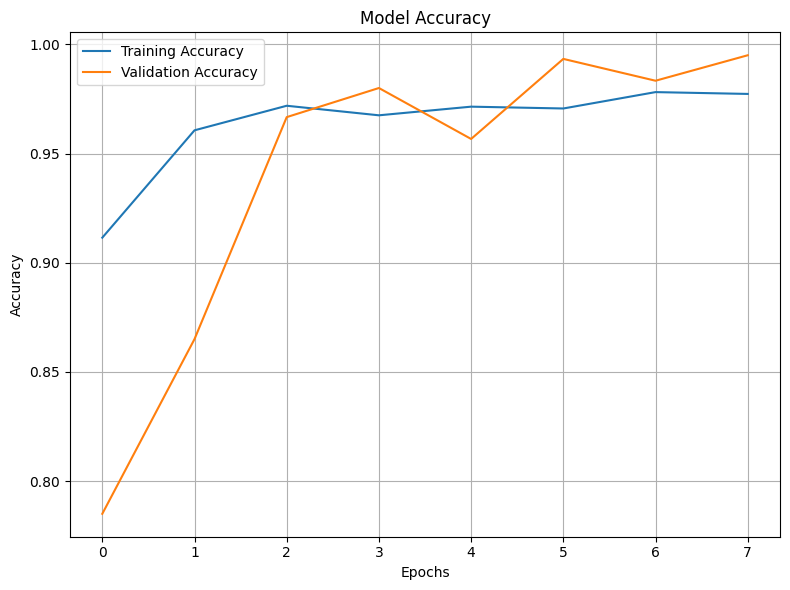

In [112]:
# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

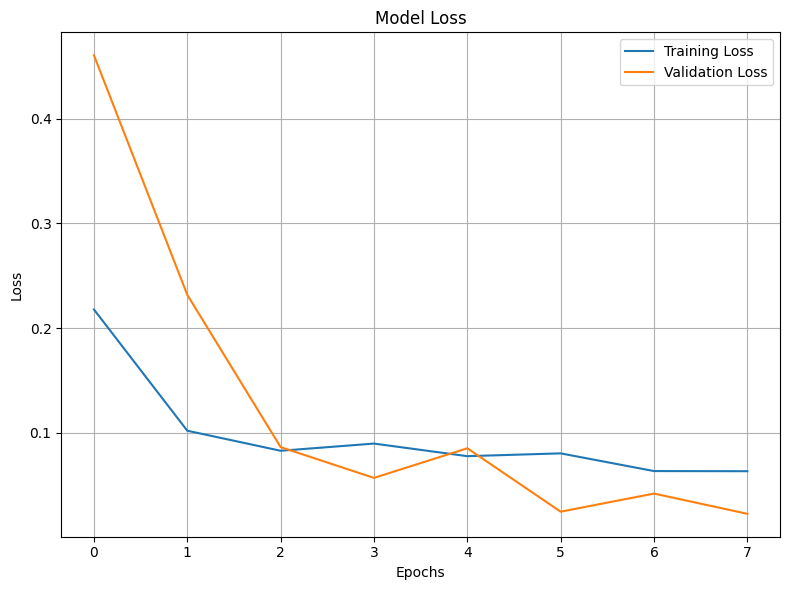

In [113]:
fig, axs = plt.subplots( figsize=(8, 6))


# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

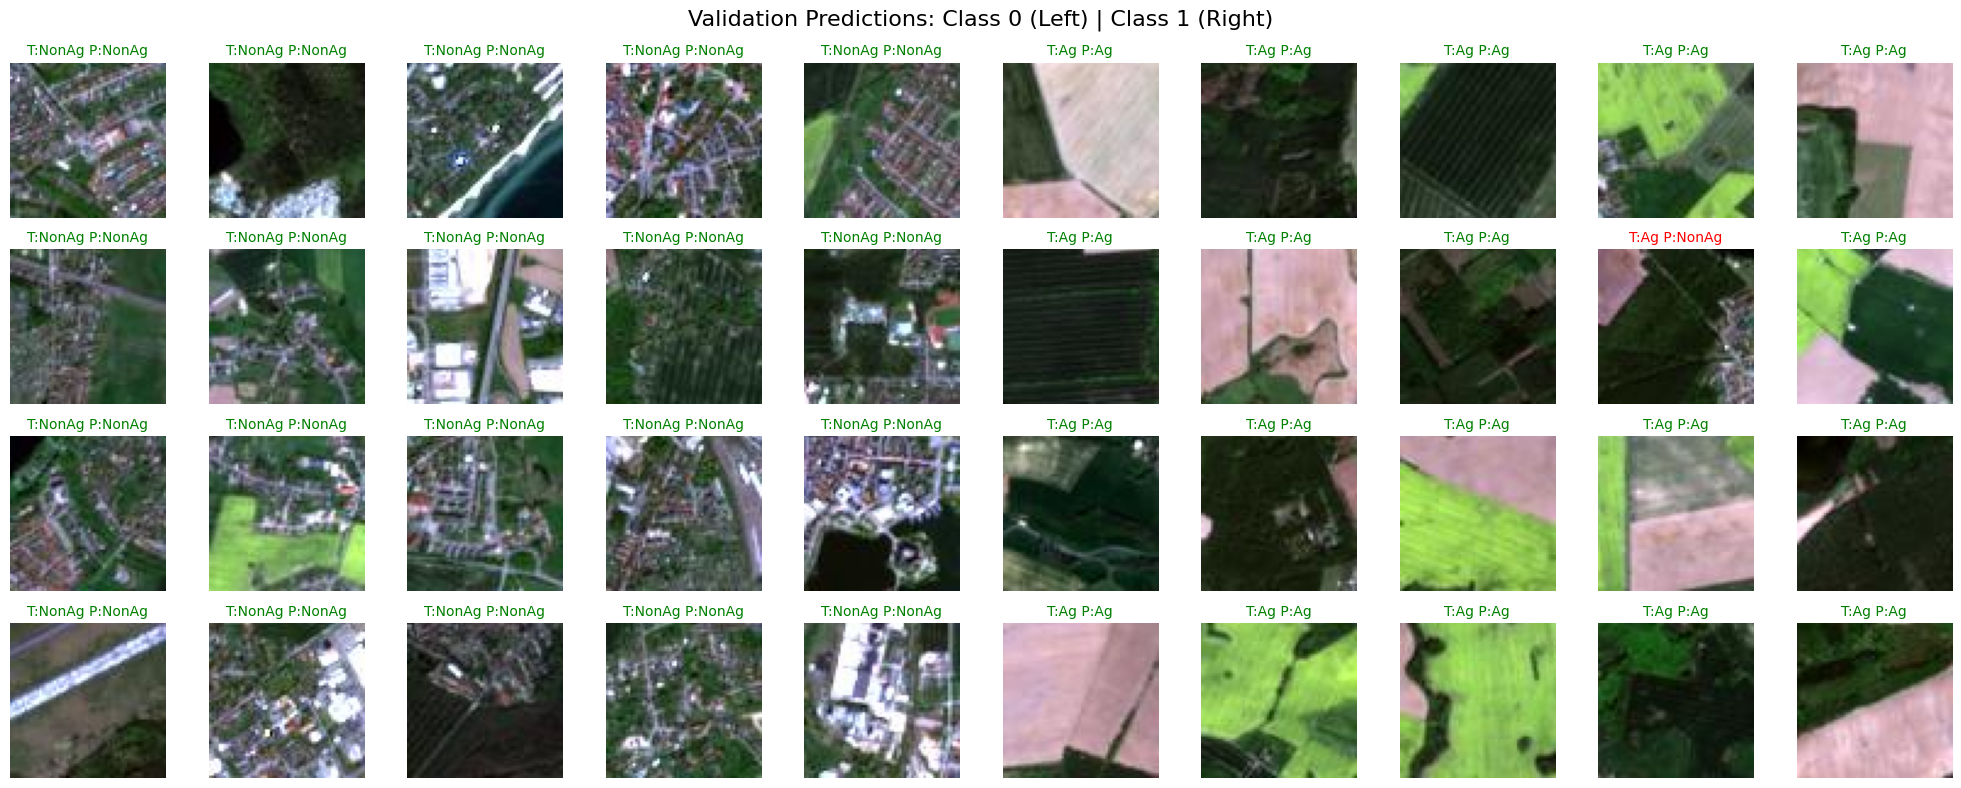

Overall accuracy: 0.995


In [120]:
from tensorflow.keras.models import load_model

model_name = "satellite_imagery_classifier.keras"
best_model = load_model(model_name)
validation_generator.reset()


# Get all validation data
val_images, val_labels = [], []
for _ in range(validation_generator.samples // validation_generator.batch_size + 1):
    batch_x, batch_y = next(validation_generator)
    val_images.extend(batch_x)
    val_labels.extend(batch_y)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Get predictions and select random samples
predictions = best_model.predict(val_images, verbose=0)
predicted_labels = (predictions > 0.5).astype(int).flatten()

class_0_idx = np.random.choice(np.where(val_labels == 0)[0], 20, replace=False)
class_1_idx = np.random.choice(np.where(val_labels == 1)[0], 20, replace=False)

# Plot
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
fig.suptitle('Validation Predictions: Class 0 (Left) | Class 1 (Right)', fontsize=16)

# Class 0 (left columns)
for i, idx in enumerate(class_0_idx):
    row, col = i // 5, i % 5
    axes[row, col].imshow(val_images[idx])
    color = 'green' if val_labels[idx] == predicted_labels[idx] else 'red'
    true_label = 'NonAg' if int(val_labels[idx]) == 0 else 'Ag'
    pred_label = 'NonAg' if predicted_labels[idx] == 0 else 'Ag'
    axes[row, col].set_title(f'T:{true_label} P:{pred_label}', color=color, fontsize=10)
    axes[row, col].axis('off')

# Class 1 (right columns)  
for i, idx in enumerate(class_1_idx):
    row, col = i // 5, (i % 5) + 5
    axes[row, col].imshow(val_images[idx])
    color = 'green' if val_labels[idx] == predicted_labels[idx] else 'red'
    true_label = 'NonAg' if int(val_labels[idx]) == 0 else 'Ag'
    pred_label = 'NonAg' if predicted_labels[idx] == 0 else 'Ag'
    axes[row, col].set_title(f'T:{true_label} P:{pred_label}', color=color, fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Overall accuracy: {np.mean(predicted_labels == val_labels):.3f}")

### Validate on unseen samples - Try on your own screenshots or images

Found 7 unseen images
Processed 7 images with shape (7, 64, 64, 3)


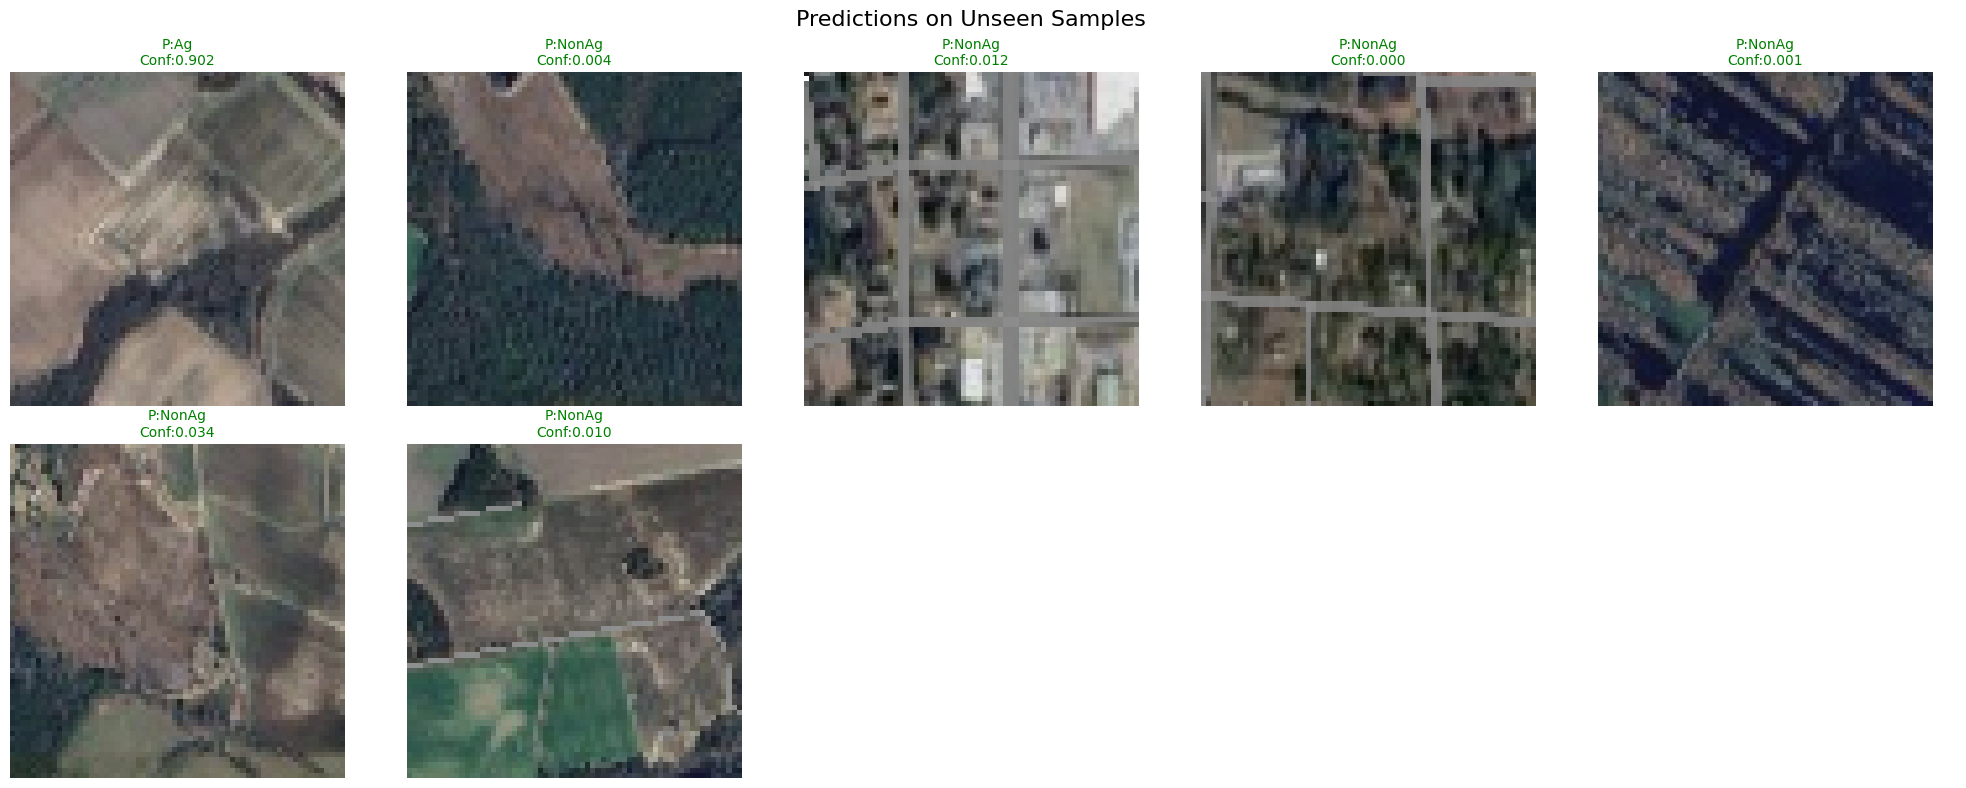

Summary: 1 Agricultural, 6 Non-Agricultural


In [122]:
# Test on unseen samples
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your unseen samples
unseen_folder = "unseenSamples"

# Get all image files from the folder
image_extensions = ('.jpg', '.jpeg', '.png', '.tiff', '.bmp')
unseen_files = [f for f in os.listdir(unseen_folder) 
                if f.lower().endswith(image_extensions)]
print(f"Found {len(unseen_files)} unseen images")

# Process each image
unseen_images = []
unseen_filenames = []
for filename in unseen_files:
    file_path = os.path.join(unseen_folder, filename)
    
    # Load and resize image to 64x64 (same as training)
    img = load_img(file_path, target_size=(64, 64))
    
    # Convert to array and normalize (same as training)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Same normalization as training
    
    unseen_images.append(img_array)
    unseen_filenames.append(filename)

unseen_images = np.array(unseen_images)
print(f"Processed {len(unseen_images)} images with shape {unseen_images.shape}")

# Get predictions
predictions = best_model.predict(unseen_images, verbose=0)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Calculate layout - use fewer columns for larger plots
n_images = len(unseen_images)
cols = 5  # Fewer columns = larger individual plots
rows = (n_images + cols - 1) // cols  # Ceiling division

# Plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
fig.suptitle('Predictions on Unseen Samples', fontsize=16)

# Handle single row case
if rows == 1:
    axes = axes.reshape(1, -1)

# Display images
for i in range(n_images):
    row = i // cols
    col = i % cols
    
    axes[row, col].imshow(unseen_images[i])
    
    # Use same labeling style as validation code
    pred_label = 'NonAg' if predicted_labels[i] == 0 else 'Ag'
    confidence = predictions[i][0]
    
    # Color based on confidence (green for high confidence, red for low)
    color = 'green' if confidence > 0.8 or confidence < 0.2 else 'red'
    
    axes[row, col].set_title(f'P:{pred_label}\nConf:{confidence:.3f}', 
                            color=color, fontsize=10)
    axes[row, col].axis('off')

# Hide empty subplots
for i in range(n_images, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Print summary
pred_ag = np.sum(predicted_labels)
pred_nonag = np.sum(1-predicted_labels)
print(f"Summary: {pred_ag} Agricultural, {pred_nonag} Non-Agricultural")